# Setup

In [1]:
%pip install scikit-learn
%pip install scikit-image
%pip install matplotlib

You should consider upgrading via the '/home/letung3105/.pyenv/versions/3.8.6/envs/MIP/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/letung3105/.pyenv/versions/3.8.6/envs/MIP/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/letung3105/.pyenv/versions/3.8.6/envs/MIP/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

import os
from enum import Enum

import matplotlib.pyplot as plt
import numpy as np
import skimage.io

INPUT_DIR = "Images"

# Task 01

Show the image for the problem.

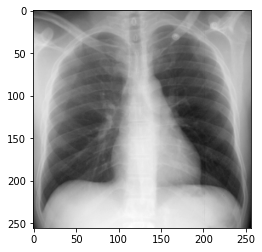

In [3]:
image = skimage.io.imread(os.path.join(INPUT_DIR, "figure_problem_set_2.tiff"))
plt.imshow(image, cmap=plt.cm.gray)
plt.show()

First, we defined a function that performs the inverse of the transformation function. Then we transform the output space into the input space and use interpolation techniques to obtain the pixel value of the pixel in the output space.

In [4]:
class InterpolationMode(Enum):
    NEAREST_NEIGHBOR = 0
    LINEAR = 1


def rotate_image(image, radians, interpolation_mode):
    rotated_image = np.zeros(image.shape, dtype=np.float32)
    radians = -radians # inversed of the rotation

    for y_prime in range(rotated_image.shape[0]):
        for x_prime in range(rotated_image.shape[1]):
            x = x_prime * np.cos(radians) + y_prime * np.sin(radians)
            y = -x_prime * np.sin(radians) + y_prime * np.cos(radians)

            # Prevent access to negative index,
            # which wrap around the array when using Numpy
            if x < 0 or y < 0:
                continue

            if interpolation_mode == InterpolationMode.NEAREST_NEIGHBOR:
                try:
                    rotated_image[y_prime,x_prime] = image[int(round(y)),int(round(x))]
                except:
                    # Might access out of bound index
                    continue
            elif interpolation_mode == InterpolationMode.LINEAR:
                # Truncated transform coordinates
                l = int(x)
                k = int(y)
                # Difference between the truncated value and the original value
                a = x - l
                b = y - k
                try:
                    # The new pixel value is the original pixel value scaled by the distance of the transformed pixel
                    # to that original pixel
                    rotated_image[y_prime,x_prime] = (
                        a * b * image[k,l] +
                        (1 - a) * b * image[k,l + 1] +
                        (1 - b) * a * image[k + 1,l] +
                        (1 - a) * (1 - b) * image[k + 1,l + 1]
                    )
                except:
                    # Might access out of bound index
                    continue

    return rotated_image

Apply a 20 degrees rotate transformation with *nearest neighbor interpolation*

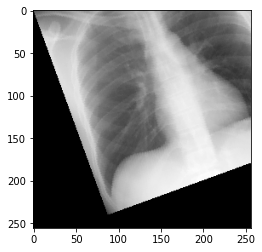

In [5]:
rotated_image = rotate_image(image,
                             np.radians(20),
                             InterpolationMode.NEAREST_NEIGHBOR)
plt.imshow(rotated_image, cmap=plt.cm.gray)
plt.show()

Apply a 20 degress rotate transformation with *linear interpolation*

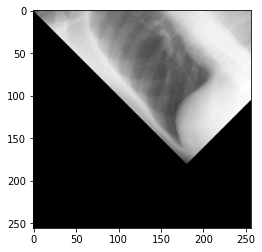

In [6]:
rotated_image = rotate_image(image, np.radians(45), InterpolationMode.LINEAR)
plt.imshow(rotated_image, cmap=plt.cm.gray)
plt.show()

From the result for the transformations, the most significant difference that can be seen is that *nearest neighbor interpolation* produces an a smoother image, where the value of every pixel can not be easily distinguish from its neighbors, as the differences in their pixel values are not significant. With *linear interpolation* we can easily see distinguish patches of pixels in the image.

# Task 02

Develop an algorithm to construct a "gradient-direction image" based on the Sobel operator. Apply this algorithm to the chest image and comment on the output image. (Hint: Compute the gradient direction and "encode" the result using a direction template consisting of 8 directions. The resulting image will be "octary", i.e., it will contain only 8 gray levels).

We define a function that performs the convolution operation between the given image and kernel. The function works naively by going through every pixel in the image, for each pixel, iterates through the kernel's values to compute the result at that pixel.

In [7]:
def convolve(image, kernel):
    assert(kernel.shape[0] == kernel.shape[1])
    assert(kernel.shape[0] % 2 == 1)
    
    kernel_size = kernel.shape[0]
    kernel_center_offset = kernel_size // 2
    # using int16 as the datatype as the gradient contains negative values
    conv_img = np.zeros(image.shape, dtype=np.int16)
    for yi in range(image.shape[0]):
        for xi in range(image.shape[1]):
            conv_val = 0
            for yk in range(kernel_size):
                for xk in range(kernel_size):
                    # Which image pixel is masked by the current value in the kernel?
                    # Edge cases are handled by considering the pixel that is outside
                    # of the image to have to value of the pixel in the image that is
                    # nearest to it
                    x_masked = xi + (xk - kernel_center_offset)
                    x_masked = max(x_masked, 0)
                    x_masked = min(x_masked, image.shape[1] - 1)
                    
                    y_masked = yi + (yk - kernel_center_offset)
                    y_masked = max(y_masked, 0)
                    y_masked = min(y_masked, image.shape[0] - 1)
                    
                    conv_val += image[y_masked,x_masked] * kernel[yk,xk]
            
            conv_img[yi,xi] = conv_val
    
    return conv_img

Here we define the sobel kernels that will be applied to out image, the gradient direction will corresponds to the transition from darker regions to brighter regions.

In [8]:
sobel_kernels = [
    np.array([
        [-1,  0,  1],
        [-2,  0,  2],
        [-1,  0,  1],
    ]),
    np.array([
        [ 1,  2,  1],
        [ 0,  0,  0],
        [-1, -2, -1],
    ]),
]

We compute the gradient of the x-axis for each pixel, which enhances the vertical edges, and visualize the resulting image

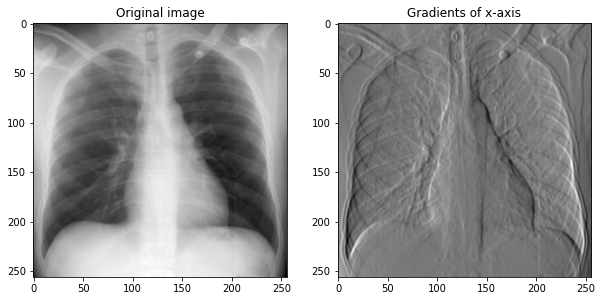

In [9]:
x_gradients = convolve(image, sobel_kernels[0])

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Original image")
axs[0].imshow(image, cmap=plt.cm.gray)
axs[1].set_title("Gradients of x-axis")
axs[1].imshow(x_gradients, cmap=plt.cm.gray)
plt.show()

We compute the gradient of the y-axis for each pixel, which enhances the horizontal edges, and visualize the resulting image

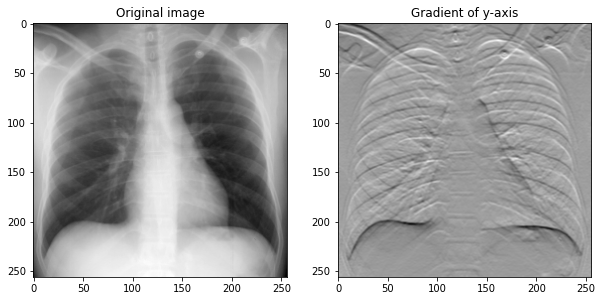

In [10]:
y_gradients = convolve(image, sobel_kernels[1])

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Original image")
axs[0].imshow(image, cmap=plt.cm.gray)
axs[1].set_title("Gradient of y-axis")
axs[1].imshow(y_gradients, cmap=plt.cm.gray)
plt.show()

With the gradients for both axes computed, we calculate the magnitude of the gradient for each pixel and visualize the resulting image

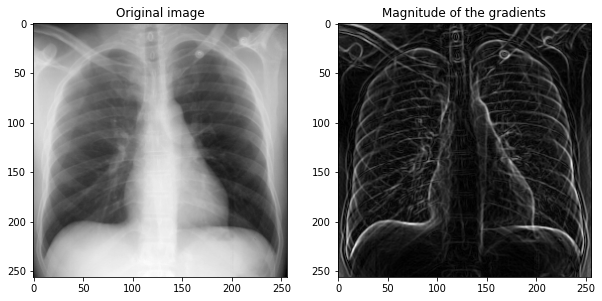

In [11]:
# Cast to float32 so the values do not overflow and can contain floating points
gradients_magnitude = np.sqrt(
    y_gradients.astype(np.float32) ** 2 + 
    x_gradients.astype(np.float32) ** 2
)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Original image")
axs[0].imshow(image, cmap=plt.cm.gray)
axs[1].set_title("Magnitude of the gradients")
axs[1].imshow(gradients_magnitude, cmap=plt.cm.gray)
plt.show()

Here we defined a function that map the gradient of each pixel to a specific color. The color of the pixel is determined by the angle of the gradient and the magnitude of the gradient. The magnitude threshold is used so that only significant edges are colored.

In [12]:
def color_gradients_direction(
    palette_rgb,
    gradients_degree,
    gradients_magnitude,
    degree_thresholds,
    magnitude_threshold
):
    colored_img = np.zeros(
        shape=(gradients_degree.shape[0], gradients_degree.shape[1], 3),
        dtype=np.uint8,
    )
    for y in range(gradients_degree.shape[0]):
        for x in range(gradients_degree.shape[1]):
            if gradients_magnitude[y,x] < magnitude_threshold:
                continue

            for (idx, threshold) in enumerate(degree_thresholds):
                if (gradients_degree[y,x] > threshold[0] and
                    gradients_degree[y,x] <= threshold[1]):
                    colored_img[y,x] = palette_rgb[idx]
                    
    return colored_img

The color mapping is defined for 8 directions, where each of the direction is a range of degees that the value of the angle of the gradient can reside in.

In [13]:
palette_rgb = [
    np.array([0x19, 0x19, 0x70]), # midnight blue
    np.array([0x00, 0x64, 0x00]), # dark green
    np.array([0xff, 0x00, 0x00]), # red
    np.array([0xff, 0xd7, 0x00]), # gold
    np.array([0x00, 0xff, 0x00]), # lime
    np.array([0x00, 0xff, 0xff]), # aqua
    np.array([0xff, 0x00, 0xff]), # fuchsia
    np.array([0xff, 0xb6, 0xc1]), # light pink
]

degree_thresholds = [
    (0, 45),      # midnight blue
    (45, 90),     # dark green
    (90, 135),    # red
    (135, 180),   # gold
    (-180, -135), # lime
    (-135, -90),  # aqua
    (-90, -45),   # funchsia
    (-45, 0),     # light pink
]

To obtain an image of the gradients' direction, we first calculate the angle value of the gradients. Then provide all the parameters to the coloring function that we define above

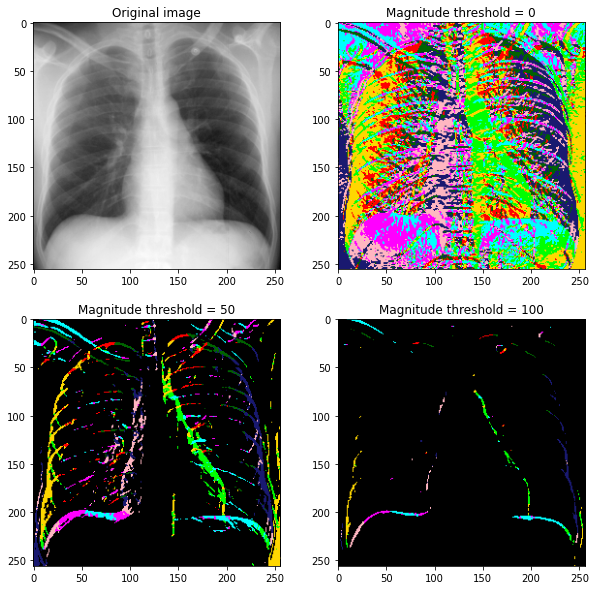

In [14]:
gradients_degree = np.degrees(np.arctan2(y_gradients, x_gradients))
colored_gradients_direction_mag0 = color_gradients_direction(
    palette_rgb,
    gradients_degree,
    gradients_magnitude,
    degree_thresholds,
    magnitude_threshold=0
)

colored_gradients_direction_mag50 = color_gradients_direction(
    palette_rgb,
    gradients_degree,
    gradients_magnitude,
    degree_thresholds,
    magnitude_threshold=50
)

colored_gradients_direction_mag100 = color_gradients_direction(
    palette_rgb,
    gradients_degree,
    gradients_magnitude,
    degree_thresholds,
    magnitude_threshold=100
)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].set_title("Original image")
axs[0,0].imshow(image, cmap=plt.cm.gray)
axs[0,1].set_title("Magnitude threshold = 0")
axs[0,1].imshow(colored_gradients_direction_mag0)
axs[1,0].set_title("Magnitude threshold = 50")
axs[1,0].imshow(colored_gradients_direction_mag50)
axs[1,1].set_title("Magnitude threshold = 100")
axs[1,1].imshow(colored_gradients_direction_mag100)
plt.show()

From the resulting images, we can observe that the colors clearly indicate the direction where darker parts transits to brighter parts, for example, the color *lime* is used for edges where darker region transits the brighter region at a -180 to -135 degree angle, the color *aqua* is used is used for edges where darker region transits the brighter region at a -135 to -90  degree angle, etc.

Without the gradient magnitude threshold, the colors are applied aggressively and we can observed the general direction of the gradient through the colors, especially at regions where changes in brightness can not be easily detect by looking at the original image. As the magnitude threshold is increased, the coloring focuses primarily on the edges leaving non-edge regions with no color.